# Convolutional Neural Network Model for Classifying Blood Clot Origins in Ischemic Strokes
### Written by Jonathan Ma - 08/22/2022

The goal of this notebook is to create a DNN model which can classify blood clot origins in ischemic stroke. Given whole slide digital pathology images, this notebook hopes to construct a model with Tensorflow, which can differentiate between the two major acute ischemic stroke (AIS) etiology subtypes: cardiac and large artery atherosclerosis.

In [29]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import openslide
from openslide import OpenSlide
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalMaxPooling2D
from sklearn.model_selection import train_test_split

from tqdm import tqdm


In [30]:
train_df = pd.read_csv("/kaggle/input/mayo-clinic-strip-ai/train.csv")
test_df = pd.read_csv("/kaggle/input/mayo-clinic-strip-ai/test.csv")

In [3]:
train_df.tail() # previewing data

,image_id,center_id,patient_id,image_num,label
749,fe9645_0,3,fe9645,0,CE
750,fe9bec_0,4,fe9bec,0,LAA
751,ff14e0_0,6,ff14e0,0,CE
752,ffec5c_0,7,ffec5c,0,LAA
753,ffec5c_1,7,ffec5c,1,LAA


We will need to preprocess our data by adding the file addresses of each patient's corresponding digital slide pathiology image. 


Additionally, because we are building a binary classifier, we will label our examples with 1 for cardiac embolisms, and 0 for large artery atheroschlerosis.

In [31]:
train_df["file_path"] = train_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/train/" + x + ".tif")
test_df["file_path"]  = test_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/test/" + x + ".tif")
train_df["Y"] = train_df["label"].apply(lambda x : 1 if x=="CE" else 0) # Creating truth labels

In [5]:
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path,Y
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif,1
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif,1
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif,0
3,01adc5_0,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif,0
4,026c97_0,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif,1


# Previewing our slides

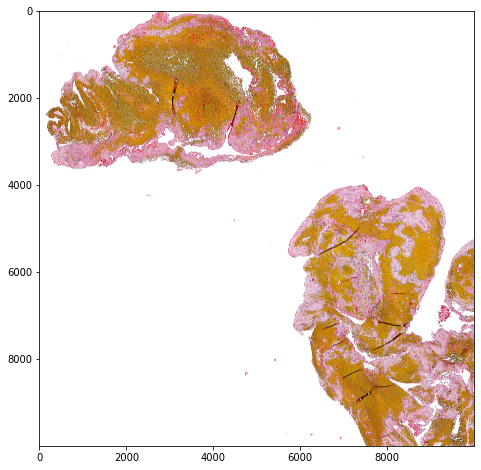

In [6]:
slide = OpenSlide(train_df.loc[142, "file_path"])
region = (0, 0)
size = (10000, 10000)
region = slide.read_region(region, 0, size)
plt.figure(figsize=(8, 8))
plt.imshow(region)
plt.show()  

These are huge images, and would take an obsene amount of time to train on without compression. So let's compress these images abit. 
We will reduce the size of our images from 10000 x 100000 to 5000 x 5000, and we will resize our images down to 512 x 512.


*This step usually takes about 50 minutes.*


I've preprocessed the images and published them [here:](https://www.kaggle.com/datasets/jonathanma02/mayo-clinic-strip-ai-preprocessed-images)



In [7]:
%%time
def preprocess(image_path):
    slide=OpenSlide(image_path)
    region= (1000,1000)    
    size  = (5000, 5000)
    image = slide.read_region(region, 0, size)
    image = tf.image.resize(image, (512, 512))
    image = np.array(image)    
    return image

"""
train_x=[]
for i in tqdm(train_df['file_path']):
    x1=preprocess(i)
    train_x.append(x1)


train_x = np.array(train_x)/255.0
train_y = train_df["Y"]
# np.save("preprocessed", train_x) # testing purposes
"""
pass

CPU times: user 11 µs, sys: 2 µs, total: 13 µs
Wall time: 16.2 µs


'\ntrain_x=[]\nfor i in tqdm(train_df[\'file_path\']):\n    x1=preprocess(i)\n    train_x.append(x1)\n\n\ntrain_x = np.array(train_x)/255.0\ntrain_y = train_df["Y"]\n# np.save("preprocessed", train_x) # testing purposes\n'

In [8]:
# Retrieving preprocessed images from published dataset
# Will not work for submission, as this requires internet access

# For testing purposes only
!pip install opendatasets --upgrade --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/jonathanma02/mayo-clinic-strip-ai-preprocessed-images")

pass



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  jonathanma02


Your Kaggle Key:

  ································


100%|██████████| 465M/465M [00:02<00:00, 218MB/s] 


# Creating Our Model

We are going to implement a Sequential Tensorflow Model. We will use:

- Adam optimization
- ~~Learning rate decay (monitored)~~ $\leftarrow$ *wasn't doing anything meaningful*
- Dropout regularization
- L2 regularization

In [11]:
train_x = np.load("mayo-clinic-strip-ai-preprocessed-images/preprocessed.npy")/255.0 #testing purposes only

model = Sequential()
input_shape = (512, 512, 4)

model.add(Conv2D(filters=32, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters=32, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu'))
# no pooling layer -- features are too minute, instead we are using a convolution layers with strides of 2
model.add(Flatten())
model.add(Dense(128, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model.add(Dropout(0.50))

model.add(Dense(1))

model.compile(
    loss = tf.keras.losses.MeanSquaredError(),    
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse"), 
             tf.keras.metrics.BinaryAccuracy(name="accuracy")],
    optimizer = tf.keras.optimizers.Adam(1e-4))

Below is a callback function which will plot our model's metrics using matplotlib.

In [12]:
import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        self.metrics["loss"]=[]
        self.metrics["val_loss"]=[]
        self.metrics["accuracy"]=[]
        self.metrics["val_accuracy"]=[]
        self.metrics["lr"]=[]
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
        
        # Plotting
        metrics = [x for x in logs if x in self.metrics and "val" not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                    self.metrics[metric], 
                    label=metric)
            if metric != "lr" and logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()
            if metric == "lr":
                axs[i].set_ylim(bottom=0, top=0.0015)
            else:
                axs[i].set_ylim(bottom=0, top=1)

        plt.tight_layout()
        plt.show()

# Training

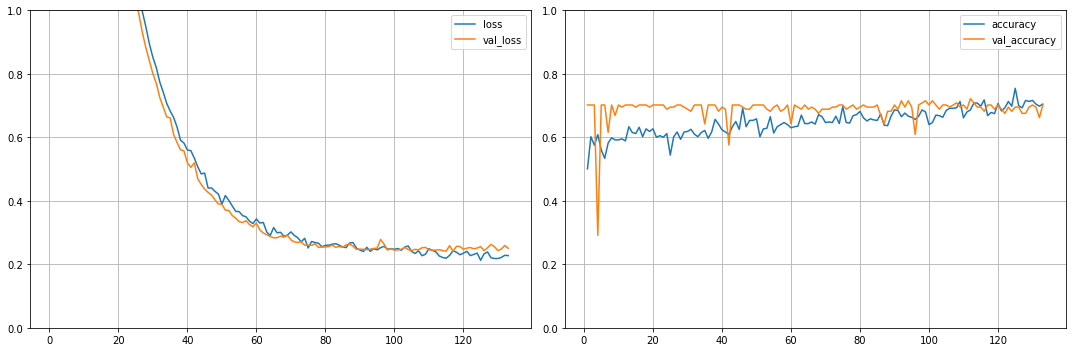

CPU times: user 7min 20s, sys: 5min 12s, total: 12min 32s
Wall time: 7min 16s


In [13]:
%%time
train_y = train_df["Y"]
train_df = None
train_x,test_x,train_y,test_y=train_test_split(train_x,train_y,test_size=0.2)

import math
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, Callback, ReduceLROnPlateau 


#lrate = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                              patience=8, min_lr=0.0001) # not doing anything meaningful for us

earstop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 16)


history = model.fit(
    train_x,
    train_y,
    epochs = 1000,
    batch_size=32,
    validation_data = (test_x,test_y),
    shuffle=True,
    verbose = 1,
    callbacks = [PlotLearning(), earstop] #lrate]
)

In [28]:
print(f"Epochs: {len(history.history['accuracy'])}")
print(f"Accuracy: {history.history['accuracy'][-1]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Loss: {history.history['loss'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")

Epochs: 133
Accuracy: 0.704809308052063
Validation Accuracy: 0.7019867300987244
Loss: 0.22741177678108215
Validation Loss: 0.2505575716495514


# Observations
We are well fitted. I have run some additional models without early stopping, and it looks like early stopping succesfully prevents us from mildly overfitting. There is generally a critical point where validation acc/loss diverges from training acc/loss. Some ideas which may improve this model include:

- Experimenting with different CNN architecture
- Data augmentation
- More computational power: larger batch sizes, more convolution layers

Unfortunately, these ideas are out of the breadth of this notebook.


 Overall, looks like our model did decently well. Our validation accuracy was steadily around 70%.

# Submission

In [34]:
test_s=[]
for i in test_df['file_path']:
    x1=preprocess(i)
    test_s.append(x1)
test_s=np.array(test_s)

sub_pred=model.predict(test_s)

In [35]:
submission = pd.DataFrame(test_df["patient_id"].copy())
submission["CE"] = sub_pred
submission["CE"] = submission["CE"].apply(lambda x : 0 if x<0 else x)
submission["CE"] = submission["CE"].apply(lambda x : 1 if x>1 else x)
submission["LAA"] = 1- submission["CE"]

submission = submission.groupby("patient_id").mean()
submission = submission[["CE", "LAA"]].round(6).reset_index()
submission

,patient_id,CE,LAA
0,006388,1.0,0.0
1,008e5c,1.0,0.0
2,00c058,1.0,0.0
3,01adc5,1.0,0.0


In [36]:
submission.to_csv("submission.csv", index = False)
!head submission.csv

patient_id,CE,LAA
006388,1.0,0.0
008e5c,1.0,0.0
00c058,1.0,0.0
01adc5,1.0,0.0


Thank you for taking the time to read my notebook. Through the construction of this model, I hoped to gain useful experience with Tensorflow, CNNs, and the machine learning process, as well as have fun playing with a meaningful dataset. For the past few months, I have been taking Andrew Ng's Deep Learning classes, and after each class, I like to try and complete a Kaggle competition to apply what I've learned. This project has been the most fun I've had, and I believe it's because now I have enough knowledge and experience to know with more confidence what I am doing. The road to mastery is a long journey, as it is with most things, but I can confidentally say that this is not my last stop. 


# References


Andrew Ng's ["Improving Deep Neural Networks"](https://www.coursera.org/learn/deep-neural-network) course


Junji Takeshima's [CNN Notebook Starter Template](https://www.kaggle.com/code/junjitakeshima/mayo-simple-cnn-starter-eng)